# 2 Geodata

`location` kolonnen kommer fra google maps og indeholder koordinat og zoom level.

Vi skal have oversat til noget vi kan bruge i vores kort.

Det bliver til `geometry` kolonnen i WKT format.

Vi bruger `geopandas` til at gøre datasættet geografisk.

Der er 2 plot i denne notebook:
1. `plot` er et plot af alle punkterne i datasættet, med Peter Mærsk.
2. `plot2` er et plot af alle breve, hvor vi har tegnet linjer mellem punkter. Her er det kun breve fra Peter Mærsk, da det er ham, vi gerne vil følge

In [28]:
# load jsonfile from disk
import json
import pandas as pd
import geopandas as gpd
import contextily as cx
from matplotlib import pyplot as plt
from shapely import wkt
from shapely.geometry import Point, Polygon



In [29]:

df = pd.read_csv('data/letters.csv')	


In [30]:
#df["location"] = df["location"].fillna("55.55,5.55,5")
df.dropna(subset=['location'], inplace=True)

# parse into geopandas
df["geometry"] = df["location"].str.split(",")

df['geometry'] = df['geometry'].apply(lambda x: x[:-1])

# convert geometry to wkt from [lat,lon] to POINT(lon lat)
df['geometry'] = df['geometry'].apply(lambda x: 'POINT (' + x[1] + ' ' + x[0] + ')')
# geometry to geometry object

df['geometry'] = df['geometry'].apply(wkt.loads)

# convert to geodataframe
gdf = gpd.GeoDataFrame(df, geometry='geometry')


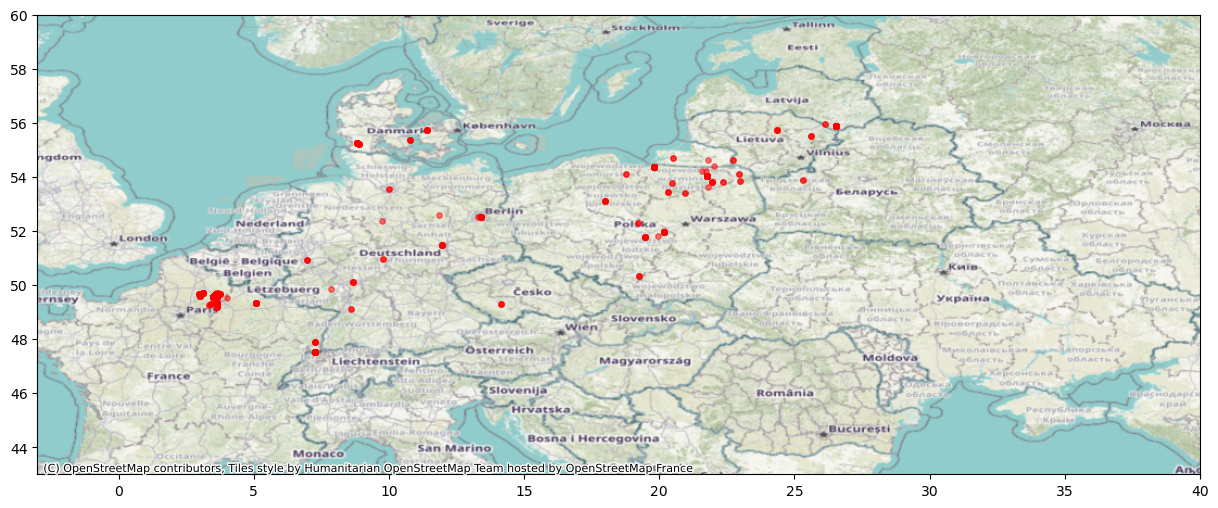

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf.plot(ax=ax, edgecolor='red',markersize=15,  alpha=0.5, color='red')
ax.set_ylim(43,60)
ax.set_xlim(-3,40)
cx.add_basemap(ax, crs='epsg:4326')


638


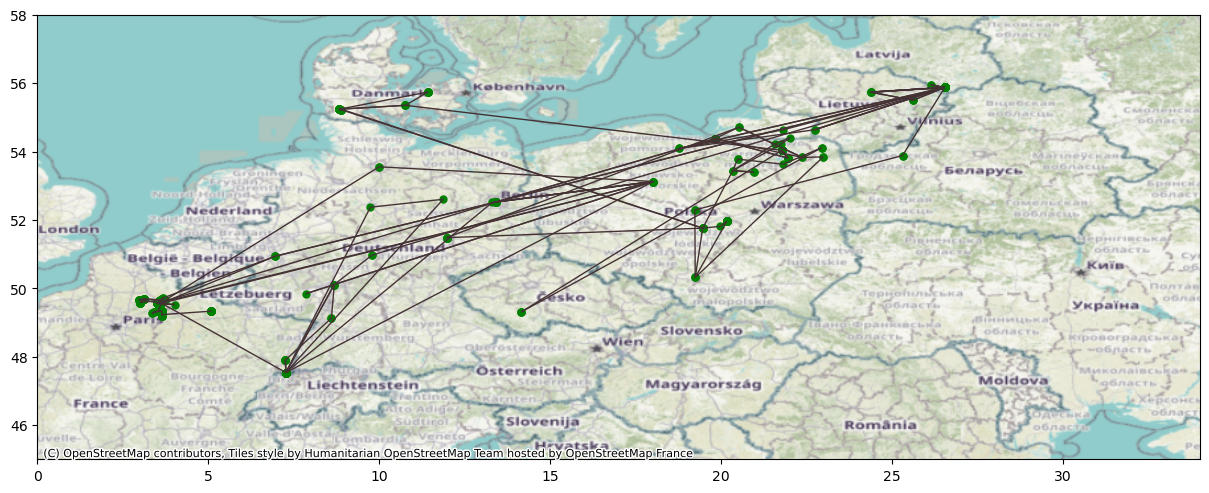

In [59]:
# create a line between the points of the letters
# sender must be "Peter Mærsk"
gdf = gpd.GeoDataFrame(df, geometry='geometry')
print(len(gdf))
gdf = gdf[gdf['sender'] == 'Peter Mærsk']
gdf = gdf.sort_values(by='id')

# only the first 100 letters
# gdf = gdf[500:]

points = gdf.geometry.tolist()
from shapely.geometry import LineString
# Create line strings between each point
lines = [LineString([points[i], points[i + 1]]) for i in range(len(points) - 1)]

# Create a new GeoDataFrame for lines
line_gdf = gpd.GeoDataFrame(geometry=lines)

# Plotting (optional)
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_ylim(45,58)
ax.set_xlim(0,34)
gdf.plot(ax=ax,marker='o', color='green', markersize=25, alpha=1)  # Plot points
line_gdf.plot(ax=ax, linewidth=1, color='#443234')  # Plot lines
cx.add_basemap(ax, crs='epsg:4326')



# create a line between the points of the letters


602
602


<Axes: title={'center': 'Days between letters'}>

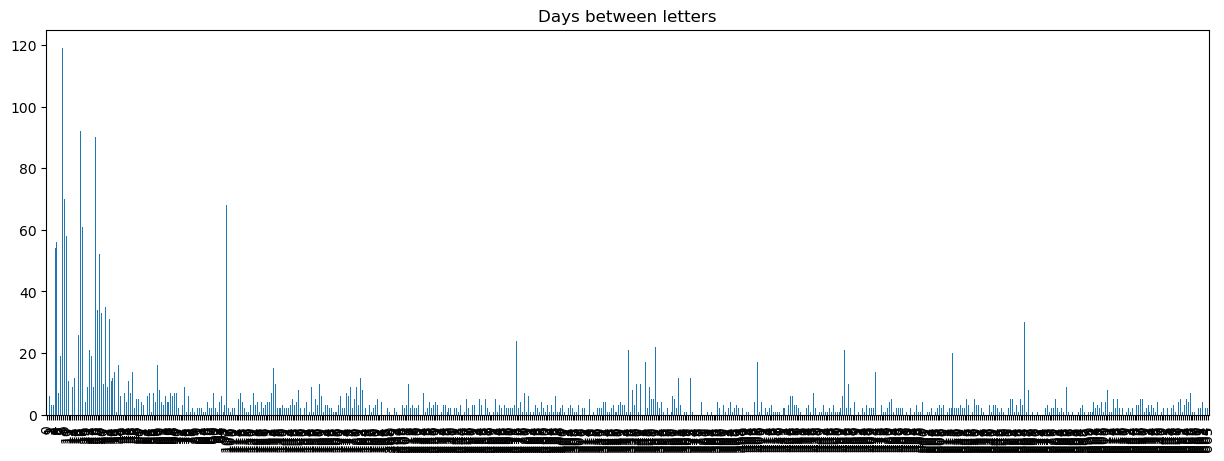

In [91]:
points = gdf.geometry.tolist()
points

# for each point in the list we calculate the distance to the previous point in kms
from geopy.distance import geodesic
distances = [0.0]
for i in range(len(points) - 1):
    distances.append(geodesic(points[i].coords[0], points[i + 1].coords[0]).km)
distances
print(len(distances))
print(len(gdf))

# add the distances to the dataframe
gdf['km_from_last'] = distances


# calculate the total distance from the first letter
gdf['km_from_start'] = gdf['km_from_last'].cumsum()


# calculate the km/hour between the letters and use 0 if the time is 0
gdf['km_per_hour'] = gdf['km_from_last'] / gdf['days_from_last'].replace(0, 1)

# the 10 fastest letters
#gdf = gdf.sort_values(by='km_per_hour', ascending=False)

# sort by date asc
gdf = gdf.sort_values(by='date')

#gdf.km_from_last.plot(kind='bar', figsize=(15, 5), title='Distance from last letter (km)')

# plot time between letters
gdf.days_from_last.plot(kind='bar', figsize=(15, 5), title='Days between letters')


#gdf







